<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[04:10:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


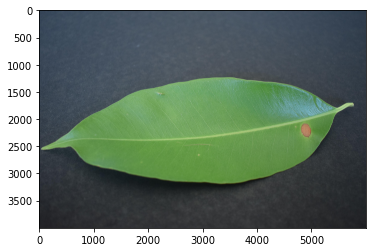

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

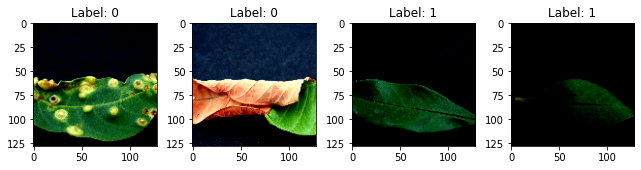

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[04:10:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[04:10:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2520225422349744 samples/sec                   batch loss = 1.9148619174957275 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2690611829083402 samples/sec                   batch loss = 0.8856542110443115 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2731086892400443 samples/sec                   batch loss = 0.6241289377212524 | accuracy = 0.48333333333333334


Epoch[1] Batch[20] Speed: 1.2736976880221045 samples/sec                   batch loss = 0.8154732584953308 | accuracy = 0.5


Epoch[1] Batch[25] Speed: 1.2769282875894399 samples/sec                   batch loss = 0.774691641330719 | accuracy = 0.5


Epoch[1] Batch[30] Speed: 1.2740011953906307 samples/sec                   batch loss = 0.45612767338752747 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2720657962766264 samples/sec                   batch loss = 0.9485334753990173 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2717253248137348 samples/sec                   batch loss = 0.7068780660629272 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.2703114907231807 samples/sec                   batch loss = 0.6112838387489319 | accuracy = 0.5666666666666667


Epoch[1] Batch[50] Speed: 1.267871586371308 samples/sec                   batch loss = 0.658941924571991 | accuracy = 0.575


Epoch[1] Batch[55] Speed: 1.2729959582120953 samples/sec                   batch loss = 0.7083665132522583 | accuracy = 0.5863636363636363


Epoch[1] Batch[60] Speed: 1.2714078700020568 samples/sec                   batch loss = 0.42273369431495667 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2660596470397625 samples/sec                   batch loss = 0.9807045459747314 | accuracy = 0.5884615384615385


Epoch[1] Batch[70] Speed: 1.2617049319491282 samples/sec                   batch loss = 0.8997860550880432 | accuracy = 0.5928571428571429


Epoch[1] Batch[75] Speed: 1.267617633356539 samples/sec                   batch loss = 0.3150005638599396 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2707140499991556 samples/sec                   batch loss = 0.9802697896957397 | accuracy = 0.621875


Epoch[1] Batch[85] Speed: 1.2752819083937204 samples/sec                   batch loss = 0.30975106358528137 | accuracy = 0.6235294117647059


Epoch[1] Batch[90] Speed: 1.2700650202540098 samples/sec                   batch loss = 0.4951586127281189 | accuracy = 0.6333333333333333


Epoch[1] Batch[95] Speed: 1.2724679242020254 samples/sec                   batch loss = 0.5756442546844482 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2659595282997584 samples/sec                   batch loss = 0.4791070818901062 | accuracy = 0.6225


Epoch[1] Batch[105] Speed: 1.2700014708118783 samples/sec                   batch loss = 1.2812557220458984 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.272520138431904 samples/sec                   batch loss = 0.23869311809539795 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2701788675301582 samples/sec                   batch loss = 0.41519874334335327 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.2718205728902923 samples/sec                   batch loss = 1.2568918466567993 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2691687055788161 samples/sec                   batch loss = 0.6802771091461182 | accuracy = 0.628


Epoch[1] Batch[130] Speed: 1.2708529459441853 samples/sec                   batch loss = 0.39089280366897583 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.2734496119470913 samples/sec                   batch loss = 0.8132050633430481 | accuracy = 0.6333333333333333


Epoch[1] Batch[140] Speed: 1.270764002840682 samples/sec                   batch loss = 0.26759257912635803 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.275514989103865 samples/sec                   batch loss = 0.9491651654243469 | accuracy = 0.6413793103448275


Epoch[1] Batch[150] Speed: 1.268238086429725 samples/sec                   batch loss = 0.6164596676826477 | accuracy = 0.6366666666666667


Epoch[1] Batch[155] Speed: 1.278738451620643 samples/sec                   batch loss = 0.5037212371826172 | accuracy = 0.6387096774193548


Epoch[1] Batch[160] Speed: 1.273578181792234 samples/sec                   batch loss = 0.42934665083885193 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.2761562064457495 samples/sec                   batch loss = 0.23888087272644043 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2671012281290586 samples/sec                   batch loss = 0.4076596796512604 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.2689937985222013 samples/sec                   batch loss = 1.1461963653564453 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2711556767958774 samples/sec                   batch loss = 0.8099557161331177 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.2690327692461882 samples/sec                   batch loss = 0.3464847803115845 | accuracy = 0.6486486486486487


Epoch[1] Batch[190] Speed: 1.2737324998794763 samples/sec                   batch loss = 0.5301968455314636 | accuracy = 0.6434210526315789


Epoch[1] Batch[195] Speed: 1.2753382316576425 samples/sec                   batch loss = 0.6935688853263855 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.2783409227419462 samples/sec                   batch loss = 0.6316317319869995 | accuracy = 0.6425


Epoch[1] Batch[205] Speed: 1.2709578840115299 samples/sec                   batch loss = 0.8286757469177246 | accuracy = 0.6426829268292683


Epoch[1] Batch[210] Speed: 1.27644010406463 samples/sec                   batch loss = 0.22287900745868683 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2695955198089388 samples/sec                   batch loss = 0.6918794512748718 | accuracy = 0.6441860465116279


Epoch[1] Batch[220] Speed: 1.2675190875249305 samples/sec                   batch loss = 0.4362836182117462 | accuracy = 0.6465909090909091


Epoch[1] Batch[225] Speed: 1.2703589109566875 samples/sec                   batch loss = 0.6900530457496643 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.2684756003236586 samples/sec                   batch loss = 0.5436881184577942 | accuracy = 0.6467391304347826


Epoch[1] Batch[235] Speed: 1.2737272779795608 samples/sec                   batch loss = 1.1180012226104736 | accuracy = 0.6468085106382979


Epoch[1] Batch[240] Speed: 1.269706304070803 samples/sec                   batch loss = 0.6167685389518738 | accuracy = 0.6458333333333334


Epoch[1] Batch[245] Speed: 1.2629679703943704 samples/sec                   batch loss = 0.7560320496559143 | accuracy = 0.6459183673469387


Epoch[1] Batch[250] Speed: 1.2619040312414442 samples/sec                   batch loss = 0.2991436719894409 | accuracy = 0.648


Epoch[1] Batch[255] Speed: 1.2607847485560755 samples/sec                   batch loss = 0.5629374384880066 | accuracy = 0.6470588235294118


Epoch[1] Batch[260] Speed: 1.2637117017880646 samples/sec                   batch loss = 0.3665759563446045 | accuracy = 0.65


Epoch[1] Batch[265] Speed: 1.2712659628887863 samples/sec                   batch loss = 0.6885403990745544 | accuracy = 0.6509433962264151


Epoch[1] Batch[270] Speed: 1.2736990417809966 samples/sec                   batch loss = 0.4511212110519409 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.2695212580970003 samples/sec                   batch loss = 0.3918967545032501 | accuracy = 0.6563636363636364


Epoch[1] Batch[280] Speed: 1.2685592355926962 samples/sec                   batch loss = 0.5422183275222778 | accuracy = 0.6553571428571429


Epoch[1] Batch[285] Speed: 1.27337151602426 samples/sec                   batch loss = 0.5687588453292847 | accuracy = 0.6570175438596492


Epoch[1] Batch[290] Speed: 1.2775322084057141 samples/sec                   batch loss = 0.33365145325660706 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2737599639097132 samples/sec                   batch loss = 0.328429251909256 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2717403630352428 samples/sec                   batch loss = 0.5695036053657532 | accuracy = 0.6625


Epoch[1] Batch[305] Speed: 1.2738365599976735 samples/sec                   batch loss = 0.4038531482219696 | accuracy = 0.6639344262295082


Epoch[1] Batch[310] Speed: 1.269102941781626 samples/sec                   batch loss = 1.0810877084732056 | accuracy = 0.6620967741935484


Epoch[1] Batch[315] Speed: 1.2709262082184696 samples/sec                   batch loss = 0.3152967691421509 | accuracy = 0.6611111111111111


Epoch[1] Batch[320] Speed: 1.2768851375284322 samples/sec                   batch loss = 0.6877985596656799 | accuracy = 0.66171875


Epoch[1] Batch[325] Speed: 1.2719486211244617 samples/sec                   batch loss = 0.5309362411499023 | accuracy = 0.6615384615384615


Epoch[1] Batch[330] Speed: 1.284980928499931 samples/sec                   batch loss = 0.4616051912307739 | accuracy = 0.6621212121212121


Epoch[1] Batch[335] Speed: 1.276025465723904 samples/sec                   batch loss = 0.6920197010040283 | accuracy = 0.6634328358208955


Epoch[1] Batch[340] Speed: 1.2682075047104568 samples/sec                   batch loss = 0.7034108638763428 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.2707337804210599 samples/sec                   batch loss = 0.455925852060318 | accuracy = 0.6652173913043479


Epoch[1] Batch[350] Speed: 1.268699675573388 samples/sec                   batch loss = 0.1670345813035965 | accuracy = 0.6692857142857143


Epoch[1] Batch[355] Speed: 1.2764086399663301 samples/sec                   batch loss = 0.618458092212677 | accuracy = 0.6704225352112676


Epoch[1] Batch[360] Speed: 1.272916276085362 samples/sec                   batch loss = 0.650802493095398 | accuracy = 0.6708333333333333


Epoch[1] Batch[365] Speed: 1.2815011725619136 samples/sec                   batch loss = 0.42828595638275146 | accuracy = 0.6698630136986301


Epoch[1] Batch[370] Speed: 1.2751270208378778 samples/sec                   batch loss = 0.8779767751693726 | accuracy = 0.6695945945945946


Epoch[1] Batch[375] Speed: 1.2693904325950025 samples/sec                   batch loss = 0.7715140581130981 | accuracy = 0.6693333333333333


Epoch[1] Batch[380] Speed: 1.2763705743654499 samples/sec                   batch loss = 0.635576605796814 | accuracy = 0.6697368421052632


Epoch[1] Batch[385] Speed: 1.2712459269621523 samples/sec                   batch loss = 1.6590330600738525 | accuracy = 0.6688311688311688


Epoch[1] Batch[390] Speed: 1.2722210986701414 samples/sec                   batch loss = 0.4041808843612671 | accuracy = 0.6692307692307692


Epoch[1] Batch[395] Speed: 1.2691754263506838 samples/sec                   batch loss = 0.2658405005931854 | accuracy = 0.6689873417721519


Epoch[1] Batch[400] Speed: 1.2750422266326649 samples/sec                   batch loss = 0.47587817907333374 | accuracy = 0.67


Epoch[1] Batch[405] Speed: 1.270733010441887 samples/sec                   batch loss = 0.42516380548477173 | accuracy = 0.6722222222222223


Epoch[1] Batch[410] Speed: 1.2728433636074512 samples/sec                   batch loss = 0.2640056312084198 | accuracy = 0.6725609756097561


Epoch[1] Batch[415] Speed: 1.2779065544481574 samples/sec                   batch loss = 0.6494695544242859 | accuracy = 0.6734939759036145


Epoch[1] Batch[420] Speed: 1.274858819011284 samples/sec                   batch loss = 0.5279694199562073 | accuracy = 0.6738095238095239


Epoch[1] Batch[425] Speed: 1.2755673567227168 samples/sec                   batch loss = 0.7517245411872864 | accuracy = 0.6741176470588235


Epoch[1] Batch[430] Speed: 1.2726403149996446 samples/sec                   batch loss = 0.49312686920166016 | accuracy = 0.6738372093023256


Epoch[1] Batch[435] Speed: 1.2731562219292853 samples/sec                   batch loss = 0.1827063262462616 | accuracy = 0.674712643678161


Epoch[1] Batch[440] Speed: 1.2740344758691773 samples/sec                   batch loss = 0.5506468415260315 | accuracy = 0.675


Epoch[1] Batch[445] Speed: 1.276728111475794 samples/sec                   batch loss = 0.2233273684978485 | accuracy = 0.6758426966292135


Epoch[1] Batch[450] Speed: 1.2712940913130062 samples/sec                   batch loss = 0.5508249402046204 | accuracy = 0.675


Epoch[1] Batch[455] Speed: 1.2721926398040346 samples/sec                   batch loss = 0.7637413144111633 | accuracy = 0.6763736263736264


Epoch[1] Batch[460] Speed: 1.2728387283945672 samples/sec                   batch loss = 0.19345629215240479 | accuracy = 0.6777173913043478


Epoch[1] Batch[465] Speed: 1.274352179101258 samples/sec                   batch loss = 0.661672055721283 | accuracy = 0.6763440860215054


Epoch[1] Batch[470] Speed: 1.2758329461346418 samples/sec                   batch loss = 0.4501875340938568 | accuracy = 0.676595744680851


Epoch[1] Batch[475] Speed: 1.2778275216299437 samples/sec                   batch loss = 0.3482184410095215 | accuracy = 0.6752631578947368


Epoch[1] Batch[480] Speed: 1.2740726925167627 samples/sec                   batch loss = 0.4220224618911743 | accuracy = 0.6755208333333333


Epoch[1] Batch[485] Speed: 1.2799324254426265 samples/sec                   batch loss = 0.773084282875061 | accuracy = 0.6762886597938145


Epoch[1] Batch[490] Speed: 1.28031755923348 samples/sec                   batch loss = 0.836879551410675 | accuracy = 0.6755102040816326


Epoch[1] Batch[495] Speed: 1.2727092457794684 samples/sec                   batch loss = 0.7397716641426086 | accuracy = 0.6762626262626262


Epoch[1] Batch[500] Speed: 1.276987866678307 samples/sec                   batch loss = 0.5329350233078003 | accuracy = 0.6755


Epoch[1] Batch[505] Speed: 1.2757176950723426 samples/sec                   batch loss = 0.3499279022216797 | accuracy = 0.6777227722772278


Epoch[1] Batch[510] Speed: 1.2779273849221287 samples/sec                   batch loss = 0.7971634864807129 | accuracy = 0.6779411764705883


Epoch[1] Batch[515] Speed: 1.273443715757238 samples/sec                   batch loss = 0.4155091345310211 | accuracy = 0.6776699029126214


Epoch[1] Batch[520] Speed: 1.2798559732390955 samples/sec                   batch loss = 0.4442864656448364 | accuracy = 0.6788461538461539


Epoch[1] Batch[525] Speed: 1.2745567426465512 samples/sec                   batch loss = 0.28654739260673523 | accuracy = 0.679047619047619


Epoch[1] Batch[530] Speed: 1.2794842898938363 samples/sec                   batch loss = 0.5711023807525635 | accuracy = 0.680188679245283


Epoch[1] Batch[535] Speed: 1.2832351090196568 samples/sec                   batch loss = 0.39081963896751404 | accuracy = 0.6794392523364486


Epoch[1] Batch[540] Speed: 1.2726918675680154 samples/sec                   batch loss = 0.2869604527950287 | accuracy = 0.6777777777777778


Epoch[1] Batch[545] Speed: 1.2759399697632663 samples/sec                   batch loss = 0.6360319256782532 | accuracy = 0.6775229357798165


Epoch[1] Batch[550] Speed: 1.2768438367106942 samples/sec                   batch loss = 0.7579755783081055 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.2746549332355177 samples/sec                   batch loss = 0.5741128325462341 | accuracy = 0.6788288288288288


Epoch[1] Batch[560] Speed: 1.2766087159058284 samples/sec                   batch loss = 0.25802290439605713 | accuracy = 0.6790178571428571


Epoch[1] Batch[565] Speed: 1.272749314019938 samples/sec                   batch loss = 0.4356919527053833 | accuracy = 0.6792035398230089


Epoch[1] Batch[570] Speed: 1.270857759237783 samples/sec                   batch loss = 0.6225639581680298 | accuracy = 0.6798245614035088


Epoch[1] Batch[575] Speed: 1.2719283708169697 samples/sec                   batch loss = 0.7115992307662964 | accuracy = 0.68


Epoch[1] Batch[580] Speed: 1.2732664689209197 samples/sec                   batch loss = 0.46180883049964905 | accuracy = 0.6801724137931034


Epoch[1] Batch[585] Speed: 1.2765663645034355 samples/sec                   batch loss = 0.4561935067176819 | accuracy = 0.6807692307692308


Epoch[1] Batch[590] Speed: 1.270235414134418 samples/sec                   batch loss = 0.339013010263443 | accuracy = 0.6826271186440678


Epoch[1] Batch[595] Speed: 1.270572682607351 samples/sec                   batch loss = 0.7418569922447205 | accuracy = 0.6827731092436975


Epoch[1] Batch[600] Speed: 1.275905425269842 samples/sec                   batch loss = 0.6378462314605713 | accuracy = 0.6833333333333333


Epoch[1] Batch[605] Speed: 1.2731116840811412 samples/sec                   batch loss = 0.6807689070701599 | accuracy = 0.6834710743801653


Epoch[1] Batch[610] Speed: 1.2746809843628888 samples/sec                   batch loss = 0.6895592212677002 | accuracy = 0.6831967213114755


Epoch[1] Batch[615] Speed: 1.2727428450007006 samples/sec                   batch loss = 0.23729798197746277 | accuracy = 0.6849593495934959


Epoch[1] Batch[620] Speed: 1.272352701304924 samples/sec                   batch loss = 0.33728498220443726 | accuracy = 0.6862903225806452


Epoch[1] Batch[625] Speed: 1.270434232722351 samples/sec                   batch loss = 0.4750552177429199 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.2713385020783545 samples/sec                   batch loss = 0.42085903882980347 | accuracy = 0.6861111111111111


Epoch[1] Batch[635] Speed: 1.2702934084833792 samples/sec                   batch loss = 0.4678848683834076 | accuracy = 0.6866141732283465


Epoch[1] Batch[640] Speed: 1.2745705891210188 samples/sec                   batch loss = 0.4284859895706177 | accuracy = 0.687109375


Epoch[1] Batch[645] Speed: 1.2718847866282865 samples/sec                   batch loss = 0.5223495364189148 | accuracy = 0.6887596899224806


Epoch[1] Batch[650] Speed: 1.2731168043259766 samples/sec                   batch loss = 0.5573469400405884 | accuracy = 0.6896153846153846


Epoch[1] Batch[655] Speed: 1.2743286580193904 samples/sec                   batch loss = 0.3063153326511383 | accuracy = 0.6893129770992367


Epoch[1] Batch[660] Speed: 1.2743842195026964 samples/sec                   batch loss = 0.5800512433052063 | accuracy = 0.6897727272727273


Epoch[1] Batch[665] Speed: 1.2717819127908594 samples/sec                   batch loss = 0.4649398922920227 | accuracy = 0.6906015037593985


Epoch[1] Batch[670] Speed: 1.2803884967843409 samples/sec                   batch loss = 0.45442497730255127 | accuracy = 0.691044776119403


Epoch[1] Batch[675] Speed: 1.2718374452414585 samples/sec                   batch loss = 0.3273089528083801 | accuracy = 0.6914814814814815


Epoch[1] Batch[680] Speed: 1.2707666016508923 samples/sec                   batch loss = 3.1686906814575195 | accuracy = 0.6919117647058823


Epoch[1] Batch[685] Speed: 1.27523634932437 samples/sec                   batch loss = 0.9503793716430664 | accuracy = 0.6912408759124088


Epoch[1] Batch[690] Speed: 1.27288759296163 samples/sec                   batch loss = 0.44098809361457825 | accuracy = 0.6920289855072463


Epoch[1] Batch[695] Speed: 1.2729429322682744 samples/sec                   batch loss = 1.3962340354919434 | accuracy = 0.6924460431654677


Epoch[1] Batch[700] Speed: 1.2704182633771761 samples/sec                   batch loss = 0.538001537322998 | accuracy = 0.6921428571428572


Epoch[1] Batch[705] Speed: 1.267820998403172 samples/sec                   batch loss = 0.6398515701293945 | accuracy = 0.6911347517730496


Epoch[1] Batch[710] Speed: 1.2772306141621028 samples/sec                   batch loss = 0.4415842592716217 | accuracy = 0.6915492957746479


Epoch[1] Batch[715] Speed: 1.2728272370748854 samples/sec                   batch loss = 0.7351596355438232 | accuracy = 0.691958041958042


Epoch[1] Batch[720] Speed: 1.2676675346114419 samples/sec                   batch loss = 0.6487894654273987 | accuracy = 0.6920138888888889


Epoch[1] Batch[725] Speed: 1.2745158827764351 samples/sec                   batch loss = 0.6768348813056946 | accuracy = 0.6913793103448276


Epoch[1] Batch[730] Speed: 1.274203710780975 samples/sec                   batch loss = 0.652015209197998 | accuracy = 0.6907534246575342


Epoch[1] Batch[735] Speed: 1.2748448694024606 samples/sec                   batch loss = 0.45526444911956787 | accuracy = 0.6914965986394558


Epoch[1] Batch[740] Speed: 1.2782706014575465 samples/sec                   batch loss = 0.5312578678131104 | accuracy = 0.6912162162162162


Epoch[1] Batch[745] Speed: 1.2695608376435947 samples/sec                   batch loss = 0.3007156550884247 | accuracy = 0.6912751677852349


Epoch[1] Batch[750] Speed: 1.2739687872933103 samples/sec                   batch loss = 0.417592316865921 | accuracy = 0.691


Epoch[1] Batch[755] Speed: 1.2716543800527846 samples/sec                   batch loss = 0.5655814409255981 | accuracy = 0.6913907284768211


Epoch[1] Batch[760] Speed: 1.2648092045140826 samples/sec                   batch loss = 0.49802762269973755 | accuracy = 0.6927631578947369


Epoch[1] Batch[765] Speed: 1.2683138280714144 samples/sec                   batch loss = 0.5471462607383728 | accuracy = 0.6931372549019608


Epoch[1] Batch[770] Speed: 1.2689729703236448 samples/sec                   batch loss = 0.6911758780479431 | accuracy = 0.6931818181818182


Epoch[1] Batch[775] Speed: 1.2681687763738596 samples/sec                   batch loss = 0.32461389899253845 | accuracy = 0.6941935483870968


Epoch[1] Batch[780] Speed: 1.2723812638298675 samples/sec                   batch loss = 0.29866620898246765 | accuracy = 0.6942307692307692


Epoch[1] Batch[785] Speed: 1.267821285823406 samples/sec                   batch loss = 0.310673326253891 | accuracy = 0.6939490445859873


[Epoch 1] training: accuracy=0.694479695431472
[Epoch 1] time cost: 646.9392054080963
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.2781420562288415 samples/sec                   batch loss = 0.23273585736751556 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.2697677097468119 samples/sec                   batch loss = 0.5065871477127075 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.2721758544935278 samples/sec                   batch loss = 0.5876620411872864 | accuracy = 0.8666666666666667


Epoch[2] Batch[20] Speed: 1.2677601640533225 samples/sec                   batch loss = 0.5459909439086914 | accuracy = 0.8375


Epoch[2] Batch[25] Speed: 1.2743582773012574 samples/sec                   batch loss = 0.7942778468132019 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2731437587467274 samples/sec                   batch loss = 0.8421190977096558 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2724306723060324 samples/sec                   batch loss = 0.5737972855567932 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2713052659639885 samples/sec                   batch loss = 0.27480971813201904 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2688148135039423 samples/sec                   batch loss = 0.5744617581367493 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2736107633868607 samples/sec                   batch loss = 0.22362209856510162 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2682686696239314 samples/sec                   batch loss = 0.4933014214038849 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2757638706072565 samples/sec                   batch loss = 0.10936150699853897 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2722783096669006 samples/sec                   batch loss = 0.5225210785865784 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2720036859352108 samples/sec                   batch loss = 1.2368700504302979 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.268704952271612 samples/sec                   batch loss = 0.3119833767414093 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2726818270399343 samples/sec                   batch loss = 0.5716238617897034 | accuracy = 0.75


Epoch[2] Batch[85] Speed: 1.2675837295630539 samples/sec                   batch loss = 0.48664531111717224 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2748146462972494 samples/sec                   batch loss = 0.42000216245651245 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2824316615359614 samples/sec                   batch loss = 0.2502821981906891 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2802704672946121 samples/sec                   batch loss = 0.2740374803543091 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.280365143196508 samples/sec                   batch loss = 0.6269472241401672 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2728216363388212 samples/sec                   batch loss = 0.7444847822189331 | accuracy = 0.740909090909091


Epoch[2] Batch[115] Speed: 1.2692157524766865 samples/sec                   batch loss = 0.6805164813995361 | accuracy = 0.7434782608695653


Epoch[2] Batch[120] Speed: 1.275062576213401 samples/sec                   batch loss = 1.3697320222854614 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.2712220387981032 samples/sec                   batch loss = 0.5296164751052856 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.2840714052988291 samples/sec                   batch loss = 0.4790205657482147 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.2819065464948556 samples/sec                   batch loss = 0.1676473319530487 | accuracy = 0.7296296296296296


Epoch[2] Batch[140] Speed: 1.277715607639357 samples/sec                   batch loss = 0.9140568375587463 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2739204200656171 samples/sec                   batch loss = 0.5243296027183533 | accuracy = 0.7275862068965517


Epoch[2] Batch[150] Speed: 1.2754766858833377 samples/sec                   batch loss = 0.4201882481575012 | accuracy = 0.73


Epoch[2] Batch[155] Speed: 1.2787938134829644 samples/sec                   batch loss = 0.23041315376758575 | accuracy = 0.7306451612903225


Epoch[2] Batch[160] Speed: 1.2719545034774926 samples/sec                   batch loss = 0.27617162466049194 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2689659637561606 samples/sec                   batch loss = 0.28177085518836975 | accuracy = 0.7303030303030303


Epoch[2] Batch[170] Speed: 1.2750571495950263 samples/sec                   batch loss = 0.13624219596385956 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.269401189621748 samples/sec                   batch loss = 0.3150222897529602 | accuracy = 0.74


Epoch[2] Batch[180] Speed: 1.269513092720934 samples/sec                   batch loss = 0.25327596068382263 | accuracy = 0.7416666666666667


Epoch[2] Batch[185] Speed: 1.2720969501760229 samples/sec                   batch loss = 0.3381296992301941 | accuracy = 0.745945945945946


Epoch[2] Batch[190] Speed: 1.2740597276249226 samples/sec                   batch loss = 0.233474999666214 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.2681559313588542 samples/sec                   batch loss = 0.6750608086585999 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.2768234302340316 samples/sec                   batch loss = 1.162513256072998 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2707770932520386 samples/sec                   batch loss = 0.7691861391067505 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2711890977219436 samples/sec                   batch loss = 0.5364087224006653 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2804578785764227 samples/sec                   batch loss = 0.17792515456676483 | accuracy = 0.7534883720930232


Epoch[2] Batch[220] Speed: 1.276115535154602 samples/sec                   batch loss = 0.8513473272323608 | accuracy = 0.7534090909090909


Epoch[2] Batch[225] Speed: 1.2754400333098652 samples/sec                   batch loss = 0.4303704500198364 | accuracy = 0.7555555555555555


Epoch[2] Batch[230] Speed: 1.2742737788714957 samples/sec                   batch loss = 0.5638121962547302 | accuracy = 0.7543478260869565


Epoch[2] Batch[235] Speed: 1.27871398866283 samples/sec                   batch loss = 0.8213678002357483 | accuracy = 0.7542553191489362


Epoch[2] Batch[240] Speed: 1.2803376867205043 samples/sec                   batch loss = 0.2102820724248886 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.27503331178286 samples/sec                   batch loss = 0.3024114966392517 | accuracy = 0.7540816326530613


Epoch[2] Batch[250] Speed: 1.276426799611561 samples/sec                   batch loss = 0.26807355880737305 | accuracy = 0.755


Epoch[2] Batch[255] Speed: 1.2777796395058147 samples/sec                   batch loss = 0.4239877760410309 | accuracy = 0.7568627450980392


Epoch[2] Batch[260] Speed: 1.275985287988537 samples/sec                   batch loss = 1.3798362016677856 | accuracy = 0.7586538461538461


Epoch[2] Batch[265] Speed: 1.2770459932351002 samples/sec                   batch loss = 0.33835169672966003 | accuracy = 0.7603773584905661


Epoch[2] Batch[270] Speed: 1.2775425201750814 samples/sec                   batch loss = 0.403730571269989 | accuracy = 0.7574074074074074


Epoch[2] Batch[275] Speed: 1.2785601176531465 samples/sec                   batch loss = 0.15708519518375397 | accuracy = 0.76


Epoch[2] Batch[280] Speed: 1.2732233727318938 samples/sec                   batch loss = 0.5990689992904663 | accuracy = 0.7580357142857143


Epoch[2] Batch[285] Speed: 1.2741695505422308 samples/sec                   batch loss = 0.6465887427330017 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.2722430948694996 samples/sec                   batch loss = 0.6133835911750793 | accuracy = 0.7594827586206897


Epoch[2] Batch[295] Speed: 1.2740348628617126 samples/sec                   batch loss = 0.7945367097854614 | accuracy = 0.7584745762711864


Epoch[2] Batch[300] Speed: 1.2753412369974184 samples/sec                   batch loss = 0.5642796158790588 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2769200266538496 samples/sec                   batch loss = 0.43447890877723694 | accuracy = 0.7622950819672131


Epoch[2] Batch[310] Speed: 1.277088862530922 samples/sec                   batch loss = 0.6490921974182129 | accuracy = 0.7588709677419355


Epoch[2] Batch[315] Speed: 1.2753787564635677 samples/sec                   batch loss = 0.4705592095851898 | accuracy = 0.7563492063492063


Epoch[2] Batch[320] Speed: 1.269904668680786 samples/sec                   batch loss = 0.6480133533477783 | accuracy = 0.75546875


Epoch[2] Batch[325] Speed: 1.2701228067346455 samples/sec                   batch loss = 0.358195036649704 | accuracy = 0.7561538461538462


Epoch[2] Batch[330] Speed: 1.2755531976460845 samples/sec                   batch loss = 0.6944989562034607 | accuracy = 0.7560606060606061


Epoch[2] Batch[335] Speed: 1.2724949476677356 samples/sec                   batch loss = 0.5899153351783752 | accuracy = 0.755223880597015


Epoch[2] Batch[340] Speed: 1.2621473441194373 samples/sec                   batch loss = 0.5345709323883057 | accuracy = 0.7544117647058823


Epoch[2] Batch[345] Speed: 1.2684038669300668 samples/sec                   batch loss = 0.36862966418266296 | accuracy = 0.7557971014492754


Epoch[2] Batch[350] Speed: 1.2667496356735422 samples/sec                   batch loss = 0.4484161138534546 | accuracy = 0.7557142857142857


Epoch[2] Batch[355] Speed: 1.2689698029616376 samples/sec                   batch loss = 0.680029034614563 | accuracy = 0.7570422535211268


Epoch[2] Batch[360] Speed: 1.274247454044288 samples/sec                   batch loss = 0.4658060073852539 | accuracy = 0.75625


Epoch[2] Batch[365] Speed: 1.2733822439807525 samples/sec                   batch loss = 0.5906555652618408 | accuracy = 0.7561643835616438


Epoch[2] Batch[370] Speed: 1.2727794392741738 samples/sec                   batch loss = 0.13438819348812103 | accuracy = 0.7574324324324324


Epoch[2] Batch[375] Speed: 1.26998762729897 samples/sec                   batch loss = 0.3669910132884979 | accuracy = 0.7573333333333333


Epoch[2] Batch[380] Speed: 1.2715864308763314 samples/sec                   batch loss = 0.2974477708339691 | accuracy = 0.7578947368421053


Epoch[2] Batch[385] Speed: 1.2722142491317858 samples/sec                   batch loss = 1.7570189237594604 | accuracy = 0.7577922077922078


Epoch[2] Batch[390] Speed: 1.26973215331071 samples/sec                   batch loss = 0.35728883743286133 | accuracy = 0.757051282051282


Epoch[2] Batch[395] Speed: 1.269562278693066 samples/sec                   batch loss = 0.24834853410720825 | accuracy = 0.7569620253164557


Epoch[2] Batch[400] Speed: 1.2732465631437015 samples/sec                   batch loss = 0.9063481688499451 | accuracy = 0.7575


Epoch[2] Batch[405] Speed: 1.2731320686964933 samples/sec                   batch loss = 0.3713184893131256 | accuracy = 0.7580246913580246


Epoch[2] Batch[410] Speed: 1.27336581385069 samples/sec                   batch loss = 0.9046504497528076 | accuracy = 0.7554878048780488


Epoch[2] Batch[415] Speed: 1.2749665512724195 samples/sec                   batch loss = 0.24228090047836304 | accuracy = 0.7560240963855421


Epoch[2] Batch[420] Speed: 1.2743090093861824 samples/sec                   batch loss = 0.3212355971336365 | accuracy = 0.756547619047619


Epoch[2] Batch[425] Speed: 1.2723254909029937 samples/sec                   batch loss = 0.6074658036231995 | accuracy = 0.758235294117647


Epoch[2] Batch[430] Speed: 1.2700877111568392 samples/sec                   batch loss = 0.5703601837158203 | accuracy = 0.7587209302325582


Epoch[2] Batch[435] Speed: 1.2682448932199475 samples/sec                   batch loss = 0.6047064661979675 | accuracy = 0.7591954022988506


Epoch[2] Batch[440] Speed: 1.2728538895287511 samples/sec                   batch loss = 0.38228508830070496 | accuracy = 0.7579545454545454


Epoch[2] Batch[445] Speed: 1.277737015755939 samples/sec                   batch loss = 0.9694110751152039 | accuracy = 0.7567415730337078


Epoch[2] Batch[450] Speed: 1.2799334019027635 samples/sec                   batch loss = 0.37442705035209656 | accuracy = 0.7577777777777778


Epoch[2] Batch[455] Speed: 1.27097781457508 samples/sec                   batch loss = 0.3537071645259857 | accuracy = 0.7582417582417582


Epoch[2] Batch[460] Speed: 1.2714980596205698 samples/sec                   batch loss = 0.7038937211036682 | accuracy = 0.7592391304347826


Epoch[2] Batch[465] Speed: 1.274971395776667 samples/sec                   batch loss = 1.451992392539978 | accuracy = 0.7586021505376344


Epoch[2] Batch[470] Speed: 1.2713583482390356 samples/sec                   batch loss = 0.6041674613952637 | accuracy = 0.7585106382978724


Epoch[2] Batch[475] Speed: 1.2751671445409989 samples/sec                   batch loss = 0.782006025314331 | accuracy = 0.7573684210526316


Epoch[2] Batch[480] Speed: 1.2672928444386902 samples/sec                   batch loss = 0.8742340207099915 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2733613681236753 samples/sec                   batch loss = 0.3519411087036133 | accuracy = 0.756701030927835


Epoch[2] Batch[490] Speed: 1.272791509087062 samples/sec                   batch loss = 0.6046611070632935 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.2725433032332212 samples/sec                   batch loss = 0.4026508033275604 | accuracy = 0.7555555555555555


Epoch[2] Batch[500] Speed: 1.2699312950051702 samples/sec                   batch loss = 0.4958694279193878 | accuracy = 0.7575


Epoch[2] Batch[505] Speed: 1.2696018607975195 samples/sec                   batch loss = 0.5830086469650269 | accuracy = 0.7569306930693069


Epoch[2] Batch[510] Speed: 1.2716032006364224 samples/sec                   batch loss = 0.2299170345067978 | accuracy = 0.7583333333333333


Epoch[2] Batch[515] Speed: 1.268800803939108 samples/sec                   batch loss = 0.3350275456905365 | accuracy = 0.7582524271844661


Epoch[2] Batch[520] Speed: 1.2735485987615986 samples/sec                   batch loss = 0.9149788022041321 | accuracy = 0.7581730769230769


Epoch[2] Batch[525] Speed: 1.2743813154724246 samples/sec                   batch loss = 0.35301196575164795 | accuracy = 0.7585714285714286


Epoch[2] Batch[530] Speed: 1.2729272861125398 samples/sec                   batch loss = 0.398246705532074 | accuracy = 0.7594339622641509


Epoch[2] Batch[535] Speed: 1.2760816605687781 samples/sec                   batch loss = 0.40027880668640137 | accuracy = 0.7602803738317757


Epoch[2] Batch[540] Speed: 1.267399684683902 samples/sec                   batch loss = 0.4342420995235443 | accuracy = 0.7606481481481482


Epoch[2] Batch[545] Speed: 1.269090653827813 samples/sec                   batch loss = 0.6183053255081177 | accuracy = 0.7610091743119266


Epoch[2] Batch[550] Speed: 1.269137790944977 samples/sec                   batch loss = 0.8891043663024902 | accuracy = 0.7604545454545455


Epoch[2] Batch[555] Speed: 1.271288311398203 samples/sec                   batch loss = 0.19918537139892578 | accuracy = 0.7608108108108108


Epoch[2] Batch[560] Speed: 1.2730461872237797 samples/sec                   batch loss = 0.20110255479812622 | accuracy = 0.7611607142857143


Epoch[2] Batch[565] Speed: 1.2703840172195129 samples/sec                   batch loss = 0.2844691276550293 | accuracy = 0.7610619469026548


Epoch[2] Batch[570] Speed: 1.2712094208157427 samples/sec                   batch loss = 0.4171328842639923 | accuracy = 0.7618421052631579


Epoch[2] Batch[575] Speed: 1.2714123984491652 samples/sec                   batch loss = 0.20588642358779907 | accuracy = 0.7626086956521739


Epoch[2] Batch[580] Speed: 1.2700112768161242 samples/sec                   batch loss = 0.0966266542673111 | accuracy = 0.7629310344827587


Epoch[2] Batch[585] Speed: 1.2779340040934188 samples/sec                   batch loss = 0.14326414465904236 | accuracy = 0.7645299145299145


Epoch[2] Batch[590] Speed: 1.2641213275627192 samples/sec                   batch loss = 0.44932273030281067 | accuracy = 0.764406779661017


Epoch[2] Batch[595] Speed: 1.2738583219302324 samples/sec                   batch loss = 0.43733060359954834 | accuracy = 0.7642857142857142


Epoch[2] Batch[600] Speed: 1.2739883286949325 samples/sec                   batch loss = 0.34202852845191956 | accuracy = 0.765


Epoch[2] Batch[605] Speed: 1.2686589985004957 samples/sec                   batch loss = 0.4841703474521637 | accuracy = 0.7648760330578512


Epoch[2] Batch[610] Speed: 1.2646517978334986 samples/sec                   batch loss = 0.4111768305301666 | accuracy = 0.7635245901639345


Epoch[2] Batch[615] Speed: 1.2748116434387786 samples/sec                   batch loss = 0.6916730999946594 | accuracy = 0.7626016260162601


Epoch[2] Batch[620] Speed: 1.2714924705757527 samples/sec                   batch loss = 0.2612845301628113 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.273077678971838 samples/sec                   batch loss = 0.32786697149276733 | accuracy = 0.7648


Epoch[2] Batch[630] Speed: 1.2729325980358683 samples/sec                   batch loss = 0.32717788219451904 | accuracy = 0.765079365079365


Epoch[2] Batch[635] Speed: 1.2709712672678697 samples/sec                   batch loss = 0.5825673341751099 | accuracy = 0.7649606299212598


Epoch[2] Batch[640] Speed: 1.2729509486575727 samples/sec                   batch loss = 0.6189374327659607 | accuracy = 0.765234375


Epoch[2] Batch[645] Speed: 1.2718372524120591 samples/sec                   batch loss = 1.7847118377685547 | accuracy = 0.7655038759689923


Epoch[2] Batch[650] Speed: 1.2767692104794333 samples/sec                   batch loss = 0.2994149327278137 | accuracy = 0.7653846153846153


Epoch[2] Batch[655] Speed: 1.2750569557880813 samples/sec                   batch loss = 0.5915946960449219 | accuracy = 0.7648854961832061


Epoch[2] Batch[660] Speed: 1.2749294435909309 samples/sec                   batch loss = 0.3833010792732239 | accuracy = 0.765530303030303


Epoch[2] Batch[665] Speed: 1.2731335178646175 samples/sec                   batch loss = 0.4913095235824585 | accuracy = 0.7650375939849624


Epoch[2] Batch[670] Speed: 1.270559307743799 samples/sec                   batch loss = 0.37685662508010864 | accuracy = 0.7656716417910447


Epoch[2] Batch[675] Speed: 1.2747651493709646 samples/sec                   batch loss = 0.3399592936038971 | accuracy = 0.7659259259259259


Epoch[2] Batch[680] Speed: 1.2741112017363596 samples/sec                   batch loss = 0.3129110038280487 | accuracy = 0.7661764705882353


Epoch[2] Batch[685] Speed: 1.2782048648717834 samples/sec                   batch loss = 0.5175961852073669 | accuracy = 0.7671532846715329


Epoch[2] Batch[690] Speed: 1.2665380089375953 samples/sec                   batch loss = 0.4046396017074585 | accuracy = 0.7677536231884058


Epoch[2] Batch[695] Speed: 1.276220276267667 samples/sec                   batch loss = 0.460540235042572 | accuracy = 0.7683453237410072


Epoch[2] Batch[700] Speed: 1.274945817210217 samples/sec                   batch loss = 0.18348558247089386 | accuracy = 0.7682142857142857


Epoch[2] Batch[705] Speed: 1.2718212477757438 samples/sec                   batch loss = 0.37489551305770874 | accuracy = 0.7680851063829788


Epoch[2] Batch[710] Speed: 1.27713601235876 samples/sec                   batch loss = 0.38532373309135437 | accuracy = 0.7683098591549296


Epoch[2] Batch[715] Speed: 1.270460785052419 samples/sec                   batch loss = 0.5888341069221497 | accuracy = 0.7685314685314686


Epoch[2] Batch[720] Speed: 1.2742501639027508 samples/sec                   batch loss = 0.5546358227729797 | accuracy = 0.7684027777777778


Epoch[2] Batch[725] Speed: 1.2728397906278712 samples/sec                   batch loss = 0.22668133676052094 | accuracy = 0.7693103448275862


Epoch[2] Batch[730] Speed: 1.2713908163524352 samples/sec                   batch loss = 0.353466272354126 | accuracy = 0.7691780821917809


Epoch[2] Batch[735] Speed: 1.2703719930234556 samples/sec                   batch loss = 0.2854729890823364 | accuracy = 0.7690476190476191


Epoch[2] Batch[740] Speed: 1.2703355370522886 samples/sec                   batch loss = 0.2522648870944977 | accuracy = 0.7692567567567568


Epoch[2] Batch[745] Speed: 1.2699033229756214 samples/sec                   batch loss = 0.2720840573310852 | accuracy = 0.7708053691275167


Epoch[2] Batch[750] Speed: 1.2767595913265177 samples/sec                   batch loss = 0.3507835865020752 | accuracy = 0.7716666666666666


Epoch[2] Batch[755] Speed: 1.2735700608234413 samples/sec                   batch loss = 0.17291778326034546 | accuracy = 0.7718543046357615


Epoch[2] Batch[760] Speed: 1.2727049011821128 samples/sec                   batch loss = 0.7442421913146973 | accuracy = 0.7723684210526316


Epoch[2] Batch[765] Speed: 1.2731374789409897 samples/sec                   batch loss = 0.8434041738510132 | accuracy = 0.7718954248366013


Epoch[2] Batch[770] Speed: 1.2711828371841614 samples/sec                   batch loss = 0.1147979348897934 | accuracy = 0.7724025974025974


Epoch[2] Batch[775] Speed: 1.2670104172637444 samples/sec                   batch loss = 0.4825640916824341 | accuracy = 0.7716129032258064


Epoch[2] Batch[780] Speed: 1.2719319386814942 samples/sec                   batch loss = 0.5187003016471863 | accuracy = 0.7708333333333334


Epoch[2] Batch[785] Speed: 1.272079202876013 samples/sec                   batch loss = 0.5198186039924622 | accuracy = 0.771656050955414


[Epoch 2] training: accuracy=0.7722081218274112
[Epoch 2] time cost: 637.4360091686249
[Epoch 2] validation: validation accuracy=0.8


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8155555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)